In [1]:
import librosa
import os

import numpy as np
import IPython
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa.display

from pyAudioAnalysis import ShortTermFeatures as aF
from scipy.io import wavfile

# Notes
## Live Piano Data
- Removed some files from the data because they were the wrong note
    - A7 mf
    - Ab7 mf
    - B0 ff
    - B7 mf
    - Bb0 ff
    - Bb7 mf
    - C1 pp
    - c8 mf
    - G7 mf
- Static interference is present in B5 ff (consider removing)
- The ff files for higher notes (6/7s) tend to have a mix of other notes in the background
    - Removed 0, 1, 7, and 8 notes due to excessive noise distortion at both ends of the note spectrum

## Online MIDI Note Data
- Converted filenames to b(flat) instead of #(sharp) to keep continuity with `Live Piano Data` filenames


In [2]:
piano_dir = "piano_files\\"
piano_midi_dir = "piano_midi_files\\"
violin_dir = "violin_files\\"
cello_dir = "cello_files\\"
clarinet_dir = "clarinet_files\\"
bass_clarinet_dir = "bass_clarinet_files\\"
saxopohne_dir = "sax_files\\"
trumpet_dir = "trumpet_files\\"

data_dir = "data\\"
single_file = "data\\C5_ff.wav"

In [3]:
instrument_to_dir = {
    "Piano": piano_dir,
    "Violin": violin_dir,
    "Cello": cello_dir,
    "BbClarinet": clarinet_dir,
    "BassClarinet": bass_clarinet_dir,
    "AltoSax": saxopohne_dir,
    "Trumpet": trumpet_dir,
}

In [4]:
sharp_to_flat_dict = {
    "C#": "Db",
    "D#": "Eb",
    "F#": "Gb",
    "G#": "Ab",
    "A#": "Bb",
}

flat_to_sharp_dict = {
    "Db": "C#",
    "Eb": "D#",
    "Gb": "F#",
    "Ab": "G#",
    "Bb": "A#",
}
note_to_index = {
    'A2': 0,
    'A3': 1,
    'A4': 2,
    'A5': 3,
    'A6': 4,
    'Ab2': 5,
    'Ab3': 6,
    'Ab4': 7,
    'Ab5': 8,
    'Ab6': 9,
    'B2': 10,
    'B3': 11,
    'B4': 12,
    'B5': 13,
    'B6': 14,
    'Bb2': 15,
    'Bb3': 16,
    'Bb4': 17,
    'Bb5': 18,
    'Bb6': 19,
    'C2': 20,
    'C3': 21,
    'C4': 22,
    'C5': 23,
    'C6': 24,
    'D2': 25,
    'D3': 26,
    'D4': 27,
    'D5': 28,
    'D6': 29,
    'Db2': 30,
    'Db3': 31,
    'Db4': 32,
    'Db5': 33,
    'Db6': 34,
    'E2': 35,
    'E3': 36,
    'E4': 37,
    'E5': 38,
    'E6': 39,
    'Eb2': 40,
    'Eb3': 41,
    'Eb4': 42,
    'Eb5': 43,
    'Eb6': 44,
    'F2': 45,
    'F3': 46,
    'F4': 47,
    'F5': 48,
    'F6': 49,
    'G2': 50,
    'G3': 51,
    'G4': 52,
    'G5': 53,
    'G6': 54,
    'Gb2': 55,
    'Gb3': 56,
    'Gb4': 57,
    'Gb5': 58,
    'Gb6': 59,
}

*`note_to_index` will need to be updated if any new notes are supported<br>
**consider adding `note_to_index` to a json file when model is needed for serving

In [5]:
# Adapted from https://towardsdatascience.com/cnns-for-audio-classification-6244954665ab

def padding(array, xx, yy):
    """
    :param array: numpy array
    :param xx: desired height
    :param yy: desirex width
    :return: padded array
    """
    h = array.shape[0]
    w = array.shape[1]
    a = max((xx - h) // 2,0)
    aa = max(0,xx - a - h)
    b = max(0,(yy - w) // 2)
    bb = max(yy - b - w,0)
    
    return np.pad(array, pad_width=((a, aa), (b, bb)), mode='symmetric')

## Piano Audio Files

In [12]:
for filename in os.listdir(piano_dir):
    audio_path = piano_dir + filename
    _, volume, note, _ = filename.split(".")

    data, sr = librosa.load(audio_path)
    # Split the data into 1 second segments
    segment_size_s = 1
    segemnt_size = segment_size_s * sr
    segments = np.array([data[i:i + segemnt_size] for i in np.arange(0, len(data), segemnt_size)], dtype=object)
    # Calculate the energy in each segment by computing the sum of the squares of samples
    segment_energy = [(s**2).sum() / len(s) for s in segments]
    max_energy_index = np.argmax(segment_energy)
    # Only keep the start of the note (segment with the most energy) and 4 seconds after
    keep_indexes = np.arange(max_energy_index, max_energy_index + 4)
    kept_segments = segments[keep_indexes]
    trim_data = np.concatenate(kept_segments)

    wavfile.write(f"data\\piano_{note}_{volume}.wav", sr, trim_data)

In [13]:
for filename in os.listdir(piano_midi_dir):
    audio_path = piano_midi_dir + filename
    note, _ = filename.split(".")
    if len(note) > 2:
        sharp_note = note[0].upper() + "#"
        note = sharp_to_flat_dict[sharp_note] + note[2]
    else:
        note = note[0].upper() + note[1]

    data, sr = librosa.load(audio_path)
    
    # There's no need to remove silence from the files since the recordings are short

    wavfile.write(f"data\\piano_{note}_midi.wav", sr, data)

## String Instrument Audio Files

In [14]:
string_directories = list(os.listdir(cello_dir))
string_directories.extend(list(os.listdir(violin_dir)))
for filename in string_directories:
    instrument, _, volume, sul, note, _, _ = filename.split(".")
    audio_path = instrument_to_dir[instrument] + filename

    data, sr = librosa.load(audio_path)
    # Split the data into 1 second segments
    segment_size_s = 1
    segemnt_size = segment_size_s * sr
    segments = np.array([data[i:i + segemnt_size] for i in np.arange(0, len(data), segemnt_size)], dtype=object)

    # Trim the audio file if it is longer than 4 seconds
    if len(segments) > 4:
        # Calculate the energy in each segment by computing the sum of the squares of samples
        segment_energy = [(s**2).sum() / len(s) for s in segments]
        max_energy_index = np.argmax(segment_energy)
        # Only keep the start of the note (segment with the most energy) and 4 seconds (or less, depending on audio length) after
        seconds_after_note = min(len(segments[max_energy_index:])-1, 4)
        keep_indexes = np.arange(max_energy_index, max_energy_index + seconds_after_note)
        kept_segments = segments[keep_indexes]
        data = np.concatenate(kept_segments)

    wavfile.write(f"data\\{instrument}_{note}_{volume}_{sul}.wav", sr, data)

## (Bass) Clarinet Audio Files

In [15]:
clarinet_directories = list(os.listdir(clarinet_dir))
clarinet_directories.extend(list(os.listdir(bass_clarinet_dir)))
for filename in clarinet_directories:
    instrument, volume, note, _, _ = filename.split(".")
    audio_path = instrument_to_dir[instrument] + filename

    data, sr = librosa.load(audio_path)
    # Split the data into 1 second segments
    segment_size_s = 1
    segemnt_size = segment_size_s * sr
    segments = np.array([data[i:i + segemnt_size] for i in np.arange(0, len(data), segemnt_size)], dtype=object)

    # Trim the audio file if it is longer than 4 seconds
    if len(segments) > 4:
        # Calculate the energy in each segment by computing the sum of the squares of samples
        segment_energy = [(s**2).sum() / len(s) for s in segments]
        max_energy_index = np.argmax(segment_energy)
        # Only keep the start of the note (segment with the most energy) and 4 seconds (or less, depending on audio length) after
        seconds_after_note = min(len(segments[max_energy_index:])-1, 4)
        keep_indexes = np.arange(max_energy_index, max_energy_index + seconds_after_note)
        kept_segments = segments[keep_indexes]
        data = np.concatenate(kept_segments)

    wavfile.write(f"data\\{instrument}_{note}_{volume}.wav", sr, data)

## Trumpet and Saxophone Audio Files (Non-Vibrato)

In [16]:
non_vibrato_directories = list(os.listdir(trumpet_dir))
non_vibrato_directories.extend(list(os.listdir(saxopohne_dir)))
for filename in non_vibrato_directories:
    instrument, _, volume, note, _, _ = filename.split(".")
    audio_path = instrument_to_dir[instrument] + filename

    data, sr = librosa.load(audio_path)
    # Split the data into 1 second segments
    segment_size_s = 1
    segemnt_size = segment_size_s * sr
    segments = np.array([data[i:i + segemnt_size] for i in np.arange(0, len(data), segemnt_size)], dtype=object)

    # Trim the audio file if it is longer than 4 seconds
    if len(segments) > 4:
        # Calculate the energy in each segment by computing the sum of the squares of samples
        segment_energy = [(s**2).sum() / len(s) for s in segments]
        max_energy_index = np.argmax(segment_energy)
        # Only keep the start of the note (segment with the most energy) and 4 seconds (or less, depending on audio length) after
        seconds_after_note = min(len(segments[max_energy_index:])-1, 4)
        keep_indexes = np.arange(max_energy_index, max_energy_index + seconds_after_note)
        kept_segments = segments[keep_indexes]
        data = np.concatenate(kept_segments)

    wavfile.write(f"data\\{instrument}_{note}_{volume}.wav", sr, data)

In [8]:
x = np.zeros((10, 2, 3))
y = x[np.newaxis, ...]
print(y.shape)

(1, 10, 2, 3)


In [6]:
height = 1025
width = 173
fmin = librosa.note_to_hz("B1")

features = []
labels = []

for filename in os.listdir(data_dir):
    file_path = data_dir + filename
    note = filename.split("_")[1]
    labels.append(note_to_index[note])
    y, sr = librosa.load(file_path)
    chroma = librosa.cqt(y=y, sr=sr, fmin=fmin, n_bins=60)
    fundamental_freq, _, _ = librosa.pyin(y, fmin=librosa.note_to_hz('B1'), fmax=librosa.note_to_hz('C7'))
    fundamental_freq = fundamental_freq.reshape([1, fundamental_freq.shape[0]])[:, :173]
    stft = librosa.stft(y)
    chroma = padding(chroma, height, width)[:1025, :173]
    fundamental_freq = padding(fundamental_freq, height, width)[:1025, :173]
    stft = padding(stft, height, width)[:1025, :173]
    image = np.dstack((chroma, fundamental_freq))
    image = np.dstack((image, stft))
    features.append(image[np.newaxis, ...])

labels = np.array(labels)
output = np.concatenate(features, axis=0)
print(output.shape)
print(labels.shape)
np.save("data.npy", output)
np.save("labels.npy", labels)


(557, 1025, 173, 3)
(557,)


E:\Downloads\Anaconda\lib\site-packages\librosa\display.py:954: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  warnings.warn(


[Text(0.5, 1.0, 'Constant Q Chromagram')]

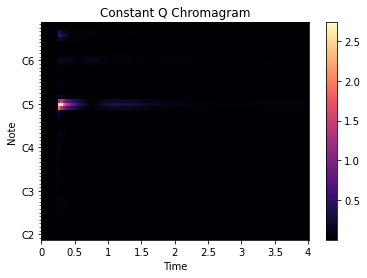

In [90]:
y, sr = librosa.load(single_file)
fmin = librosa.note_to_hz("B1")
chroma = librosa.cqt(y=y, sr=sr, fmin=fmin, n_bins=60)
fig, ax = plt.subplots()
img = librosa.display.specshow(chroma, y_axis='cqt_note', x_axis='time', ax=ax, fmin=fmin)
fig.colorbar(img, ax=ax)
ax.set(title='Constant Q Chromagram')

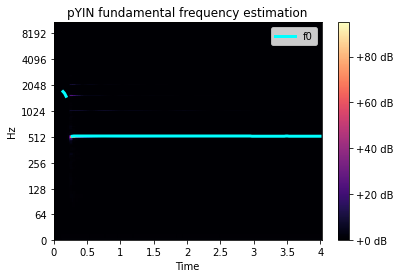

In [91]:
y, sr = librosa.load(single_file)
f0, _, _ = librosa.pyin(y, fmin=librosa.note_to_hz('B1'), fmax=librosa.note_to_hz('C7'))
times = librosa.times_like(f0, sr)

D = librosa.stft(y)
fig, ax = plt.subplots()
img = librosa.display.specshow(D, x_axis='time', y_axis='log', ax=ax)
ax.set(title='pYIN fundamental frequency estimation')
fig.colorbar(img, ax=ax, format="%+2.f dB")
ax.plot(times, f0, label='f0', color='cyan', linewidth=3)
ax.legend(loc='upper right')